In [76]:
from typing import List, Optional
from autograd import grad, jacobian, elementwise_grad
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from tqdm import tqdm
import math
import scipy 
from scipy import linalg
from numpy import linalg as LA

sys.path.insert(0, os.path.join(".."))
%reload_ext autoreload
%autoreload 2

In [77]:
from lib import problems as pr
from lib import optimisers as opt
from lib import utils as ut
from lib.logistic_regression import LogisticRegression

In [78]:
plt.rcParams['figure.figsize'] = 15, 8
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

In [79]:
A = np.genfromtxt("../data/framingham.csv", delimiter=',', missing_values='NA', filling_values=0, skip_header=1, usecols=(1,4,5,9,10,11,12,13,14))
b = np.genfromtxt("../data/framingham.csv", delimiter=',', skip_header=1, usecols=(15))

In [80]:
print(A.shape)

(4240, 9)


In [81]:
np.unique(b, return_counts=True)

(array([0., 1.]), array([3596,  644], dtype=int64))

In [82]:
A_test = A[4000:]
b_test = A[4000:]
A = A[:4000]
b = b[:4000]
A = A / A.max(axis=0)

In [83]:
print(A.shape)
print(b.shape)

(4000, 9)
(4000,)


In [84]:
problem = LogisticRegression(0.2, A, b, L_y=8)

In [85]:
print(problem.L_xy, problem.mu_xy)
ny, nx = problem.A.shape

0.02066722750032482 6.489004005478079e-13


In [86]:
print(problem.loss(np.ones(nx), -np.ones(ny)))
print(problem.xopt)
print(problem.yopt)

3.658361646525387
[-0.38517606 -0.06110253  0.0092679  -0.19812873 -0.24543138 -0.33592473
 -0.27207349 -0.32503904 -0.10100066]
[0.23393141 0.28088225 0.10680747 ... 0.12780196 0.07806431 0.14138974]


In [88]:
params = {"apdg": None,
          'lpd': None,
          'altgd': None,
          'simgd': None,
          # 'avg': None,
          'eg': None,
          'omd': None,
          'AA': None,
          "smm": None
         }

x0 = np.random.randn(nx, )
y0 = np.random.randn(ny, )
iteration = 10000
methods_dict = ut.main(problem, iteration, x0.copy(), y0.copy(), params, eps=1e-6)

OMD: 100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [2:23:46<00:00,  1.16it/s]


AltGDA-AM couldn't be used in such parameters' settings


LPD: 100%|██████████████████████████████████████████████████████████████████████████████████| 10000/10000 [4:45:13<00:00,  1.71s/it]


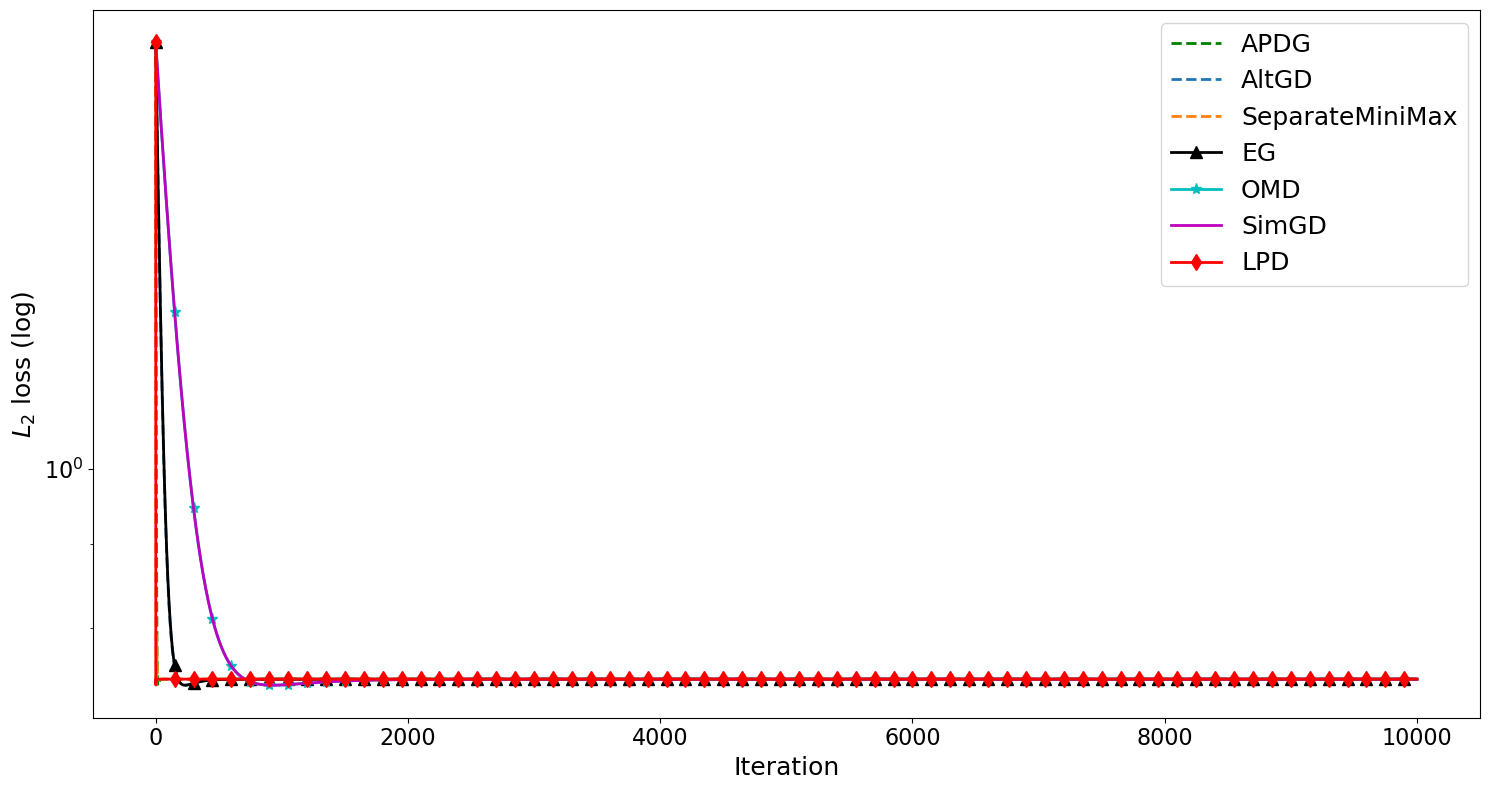

In [89]:
%matplotlib inline
plot_interval = 1
markevery=150
for method in methods_dict:
    if method not in []:
        plt.semilogy(np.arange(0, len(methods_dict[method]["loss_hist"])+plot_interval-1, plot_interval),
                     methods_dict[method]["loss_hist"][::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
plt.xlabel("Iteration")
plt.ylabel(r"$L_2$ loss (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"LogisticOnFramingham_loss_iter{iteration}_nx{nx}_ny{ny}.jpg"))
plt.savefig(os.path.join("..", "figures", f"LogisticOnFramingham_loss_iter{iteration}_nx{nx}_ny{ny}.pdf"))

APDG 0.32530637650411953
AltGD 0.32530637650411953
SeparateMiniMax 0.32530637650411953
EG 0.32530637650411953
OMD 0.32530637650411953
SimGD 0.32530637650411953
LPD 0.32530637650411953


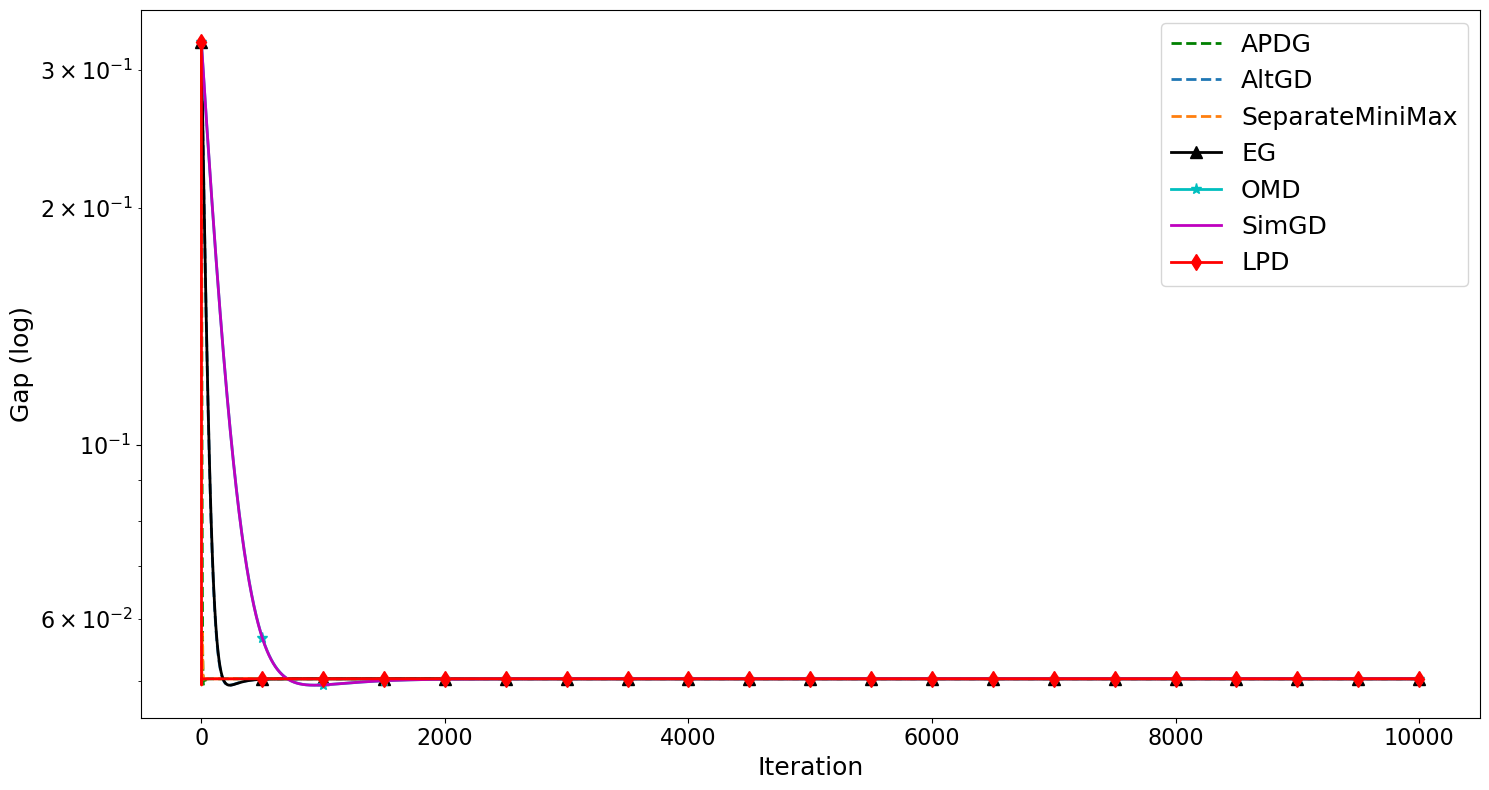

In [92]:
# TODO: cut the plot :1500
plot_interval = 1
markevery=500
for method in methods_dict:
    if method not in []:
        _gap =methods_dict[method]["class"].all_metrics["gap"]
        print(method, _gap[0])
        plt.semilogy(np.arange(0, len(_gap)+plot_interval-1, plot_interval),
                     _gap[::plot_interval],
                     methods_dict[method]["marker"],
                     markevery=markevery,
                     label=method
                    )
# plt.xscale('log')
plt.xlabel("Iteration")
plt.ylabel("Gap (log)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join("..", "figures", f"LogisticOnFramingham_gap_iter{iteration}_nx{nx}_ny{ny}.jpg"))
plt.savefig(os.path.join("..", "figures", f"LogisticOnFramingham_gap_iter{iteration}_nx{nx}_ny{ny}.pdf"))

In [90]:
from sklearn.metrics import classification_report
x_solution = methods_dict["LPD"]["x_hist"][-1]
print(classification_report(b_test.astype(int), -1*(1/(1 + np.exp(-A_test.dot(x_solution))) > 0.5).astype(int)))

ValueError: Classification metrics can't handle a mix of multiclass-multioutput and binary targets

In [56]:
print(methods_dict["LPD"]["x_hist"][-1])

[-0.54956077 -0.09224096  0.00401995 -0.27771438 -0.34876138 -0.46754504
 -0.37700065 -0.45064205 -0.14668327]


**AltGD has the same rate as EG**